In [2]:
import pyprob
from pyprob import Model
from pyprob.distributions import Categorical, Normal, Uniform

import torch
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure();

<Figure size 432x288 with 0 Axes>

In [3]:
update = np.zeros(3)

In [4]:
update[torch.tensor(2)]

0.0

In [5]:
class GillespieUnknownRate(Model):
    def __init__(self, steps = 100):
        super().__init__(name='categorical') # give the model a name
        
        ## Rate parameters we are not interested in
        self.p2_prior = .1
        self.p3_prior = .9
        
        ## rate parameter of interest
        self.p1_prior = .5
        self.p1_std_prior = .1
        
        ## Species starting points
        self.s1 = 10
        self.s2 = 10
        self.s3 = 10
        
        self.steps = 100
        
        ## Needed for update rule
        #self.protein = 1.5

    def forward(self): # Needed to specifcy how the generative model is run forward
        # sample the (latent) variable to be inferred:
        prior = pyprob.sample(Normal(self.p1_prior, self.p1_std_prior)) # NOTE: sample -> denotes latent variables
        #prior = prior * self.protein
        
        for i in range(self.steps):
            # define the likelihood
            likelihood = pyprob.sample(Categorical([self.s1*prior, 
                                                    self.s2*self.p2_prior, 
                                                    self.s3*self.p3_prior]))

            update = np.zeros(3)
            update[likelihood] = 1

            new_s1 = Normal(self.s1 + update[0], .001)
            new_s2 = Normal(self.s2 + update[1], .001)
            new_s3 = Normal(self.s3 + update[2], .001)
            
            self.s1 = new_s1
            self.s2 = new_s2
            self.s3 = new_s3

            # new_s1 = Normal(self.s1 + update[0], .001)
            # new_s2 = Normal(self.s2 + update[1], .001)
            # new_s3 = Normal(self.s3 + update[2], .001)

            self.s1 = pyprob.sample(new_s1)
            self.s2 = pyprob.sample(new_s2)
            self.s3 = pyprob.sample(new_s3)
            
            # Lets add two observed variables
            # -> the 'name' argument is used later to assignment values:
            pyprob.observe(new_s1, name='obs0_{0}_s1'.format(str(i)))
            pyprob.observe(new_s1, name='obs1_{0}_s1'.format(str(i)))
            
            pyprob.observe(new_s2, name='obs0_{0}_s2'.format(str(i)))
            pyprob.observe(new_s2, name='obs1_{0}_s2'.format(str(i)))
            
            pyprob.observe(new_s3, name='obs0_{0}_s3'.format(str(i)))
            pyprob.observe(new_s3, name='obs1_{0}_s3'.format(str(i)))

        # return the latent quantity of interest
        return prior
    
model = GillespieUnknownRate()

In [6]:
model

Model(name:categorical)

In [77]:
prior = model.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:00:01:30 | 0d:00:00:00 | #################### | 1000/1000 | 1000.00 | 11.07       


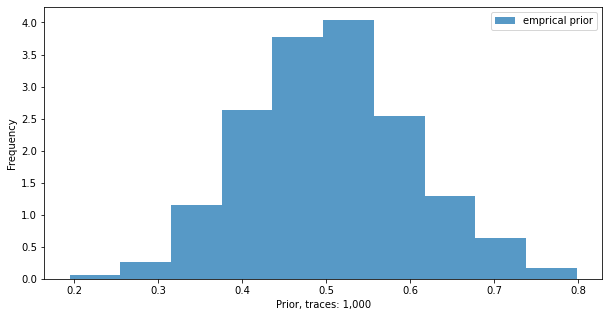

In [78]:
prior.plot_histogram(show=False, alpha=0.75, label='emprical prior')
plt.legend();
plt.show()

In [11]:
with open('data/test_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [12]:
data_0_s1 = {"obs0_{0}_s1".format(x) : data[0][x][0] for x in range(100)}
data_0_s2 = {"obs0_{0}_s2".format(x) : data[0][x][1] for x in range(100)}
data_0_s3 = {"obs0_{0}_s3".format(x) : data[0][x][2] for x in range(100)}

data0 = dict(data_0_s1, **data_0_s2)
data0.update(data_0_s3)

data_1_s1 = {"obs1_{0}_s1".format(x) : data[1][x][0] for x in range(100)}
data_1_s2 = {"obs1_{0}_s2".format(x) : data[1][x][1] for x in range(100)}
data_1_s3 = {"obs1_{0}_s3".format(x) : data[1][x][2] for x in range(100)}

data1 = dict(data_1_s1, **data_1_s2)
data1.update(data_1_s3)

obs_data = dict(data0, **data1)

In [83]:
# sample from posterior (2000 samples)
posterior = model.posterior_results(
                             num_traces=100, # the number of samples estimating the posterior
                             inference_engine=pyprob.InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS, # specify which inference engine to use
                             observe=obs_data # assign values to the observed values
                             )

Time spent  | Time remain.| Progress             | Trace   | Accepted|Smp reuse| Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 100/100 |   0.00% |  99.75% | 9.39        


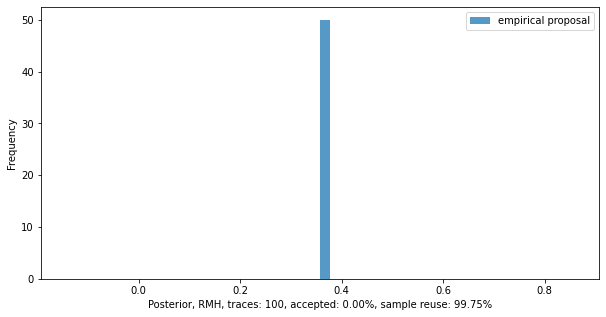

In [84]:
#posterior_unweighted = posterior_nn.unweighted()
posterior.plot_histogram(show=False, bins=50, alpha=0.75, label='empirical proposal')

# correct_dists.plot_posterior(min(posterior.values_numpy()),
#                              max(posterior.values_numpy()))
plt.legend();

In [8]:
dim_0_s1 = {"obs0_{0}_s1".format(x) : {'dim' : 32} for x in range(100)}
dim_0_s2 = {"obs0_{0}_s2".format(x) : {'dim' : 32} for x in range(100)}
dim_0_s3 = {"obs0_{0}_s3".format(x) : {'dim' : 32} for x in range(100)}

dim0 = dict(dim_0_s1, **dim_0_s2)
dim0.update(dim_0_s3)

dim_1_s1 = {"obs1_{0}_s1".format(x) : {'dim' : 32} for x in range(100)}
dim_1_s2 = {"obs1_{0}_s2".format(x) : {'dim' : 32} for x in range(100)}
dim_1_s3 = {"obs1_{0}_s3".format(x) : {'dim' : 32} for x in range(100)}

dim1 = dict(dim_1_s1, **dim_1_s2)
dim1.update(dim_1_s3)

dim_data = dict(dim0, **dim1)

In [9]:
model.learn_inference_network(num_traces=2000,
                              observe_embeddings=dim_data,
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable obs0_0_s1: reshape not specified, using shape torch.Size([]).
Observable obs0_0_s1: using embedding dim torch.Size([32]).
Observable obs0_0_s1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0_0_s1: embedding depth not specified, using the default 2.
Observable obs0_1_s1: reshape not specified, using shape torch.Size([]).
Observable obs0_1_s1: using embedding dim torch.Size([32]).
Observable obs0_1_s1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0_1_s1: embedding depth not specified, using the default 2.
Observable obs0_2_s1: reshape not specified, using shape torch.Size([]).
Observable obs0_2_s1: using embedding dim torch.Size([32]).
Observable obs0_2_s1: observe embedding not specified, using the default FEEDFORWARD.
Observable obs0_2_s1: embedding depth not specified, using the default 2.
Observable obs0_3_s1: reshape not specified, using shape torch.Size([]).
Observable obs

In [13]:
# sample from posterior (2000 samples)
posterior_nn = model.posterior_results(
                             num_traces=2000, # the number of samples estimating the posterior
                             inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                             observe=obs_data# assign values to the observed values
                             )

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


KeyboardInterrupt: 